In [1]:
import tensorflow as tf
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
tf.enable_v2_behavior()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
#1 Load the beans dataset.
#2 Split the data into training and test dataset.
(bn_train, bn_validation, bn_test), bn_info = tfds.load(name = 'beans', split = ['train', 'validation', 'test'],
                                                       as_supervised = True, with_info = True)
print(bn_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='C:\\Users\\srgra\\tensorflow_datasets\\beans\\0.1.0',
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo 

In [3]:
for image, label in bn_train.take(1):
    print(image.shape, label)

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


In [4]:
print(bn_info.features["label"].num_classes)
print(bn_info.features["label"].names)

3
['angular_leaf_spot', 'bean_rust', 'healthy']


In [5]:
print(bn_info.features.shape)
print(bn_info.features.dtype)
print(bn_info.features['image'].shape)
print(bn_info.features['image'].dtype)

{'image': (500, 500, 3), 'label': ()}
{'image': tf.uint8, 'label': tf.int64}
(500, 500, 3)
<dtype: 'uint8'>


In [6]:
# Image parameters:
image_height = 500
image_width = 500
num_channels = 3
num_classes = 3

# Pipeline hyperparameters:
batch_size = 32

def normalize_image(image, label, target_height = 500, target_width = 500):
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label

In [7]:
bn_train = bn_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_train = bn_train.cache().shuffle(1000)
bn_train = bn_train.shuffle(bn_info.splits['train'].num_examples)
bn_train = bn_train.batch(batch_size)
bn_train = bn_train.prefetch(tf.data.experimental.AUTOTUNE)

bn_validation = bn_validation.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_validation = bn_validation.batch(batch_size)
bn_validation = bn_validation.cache()
bn_validation = bn_validation.prefetch(tf.data.experimental.AUTOTUNE)

bn_test = bn_test.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_test = bn_test.batch(batch_size)
bn_test = bn_test.cache()
bn_test = bn_test.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
def return_class_labels(ds):
    l_labels = []
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(bn_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(bn_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(bn_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


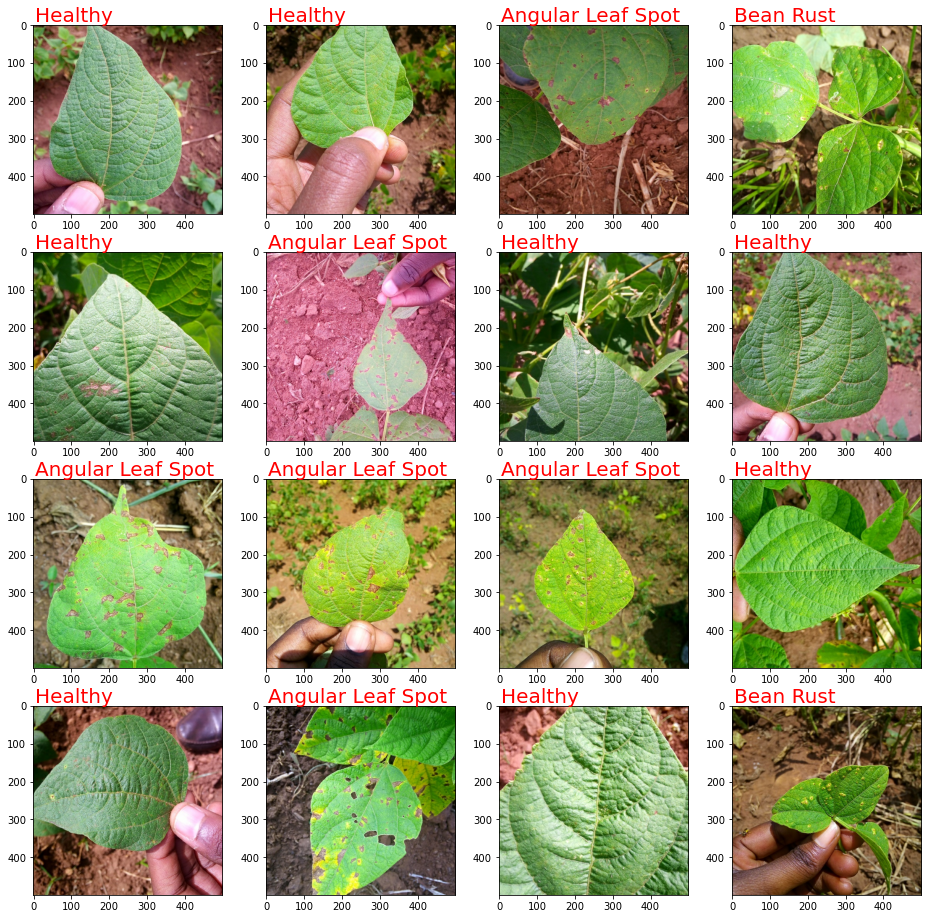

In [9]:
example = bn_train.take(1)

for sample in example:
    image, label = sample[0], sample[1]
    #convert them to np
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))  

In [10]:
#3 Build a CNN network to perform image classification using TensorFlow. Does it overfit or underfit the data? Please justify 
#  your answer.
model = models.Sequential()

input_shape = image.shape

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape[1:]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(3))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 64)      1

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [13]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
history = model.fit(bn_train, epochs=5, 
                    validation_data=(bn_validation), callbacks=[callback], verbose = 1)

Epoch 1/5
33/33 [==============================] - 280s 8s/step - loss: 2.5604 - accuracy: 0.4294 - val_loss: 0.9125 - val_accuracy: 0.5940
Epoch 2/5
33/33 [==============================] - 258s 8s/step - loss: 0.8219 - accuracy: 0.6325 - val_loss: 0.7322 - val_accuracy: 0.6842
Epoch 3/5
33/33 [==============================] - 246s 7s/step - loss: 0.6890 - accuracy: 0.7176 - val_loss: 0.7383 - val_accuracy: 0.6692
Epoch 4/5
33/33 [==============================] - 259s 8s/step - loss: 0.5760 - accuracy: 0.7660 - val_loss: 0.6773 - val_accuracy: 0.6917
Epoch 5/5
33/33 [==============================] - 257s 8s/step - loss: 0.4338 - accuracy: 0.8327 - val_loss: 0.9126 - val_accuracy: 0.7218
CPU times: total: 1h 58min 47s
Wall time: 21min 39s


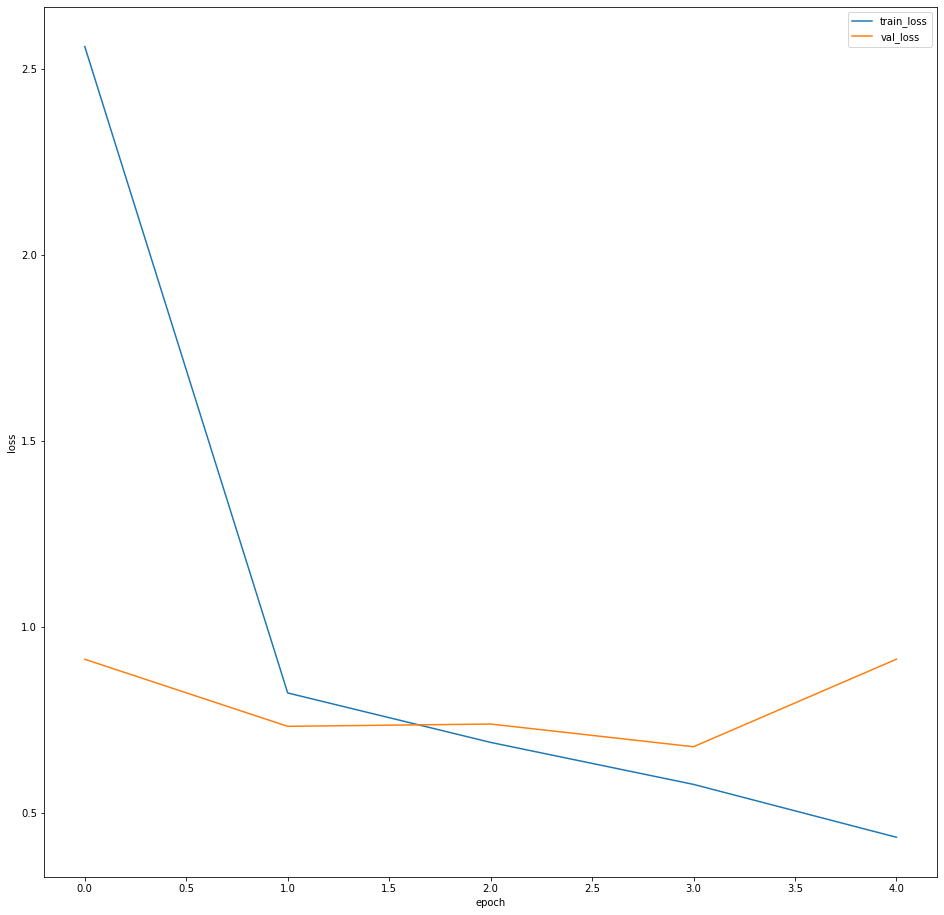

In [14]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data = train_history)
sns.lineplot(x='epoch', y ='val_loss', data = train_history)
plt.legend(labels=['train_loss', 'val_loss'])

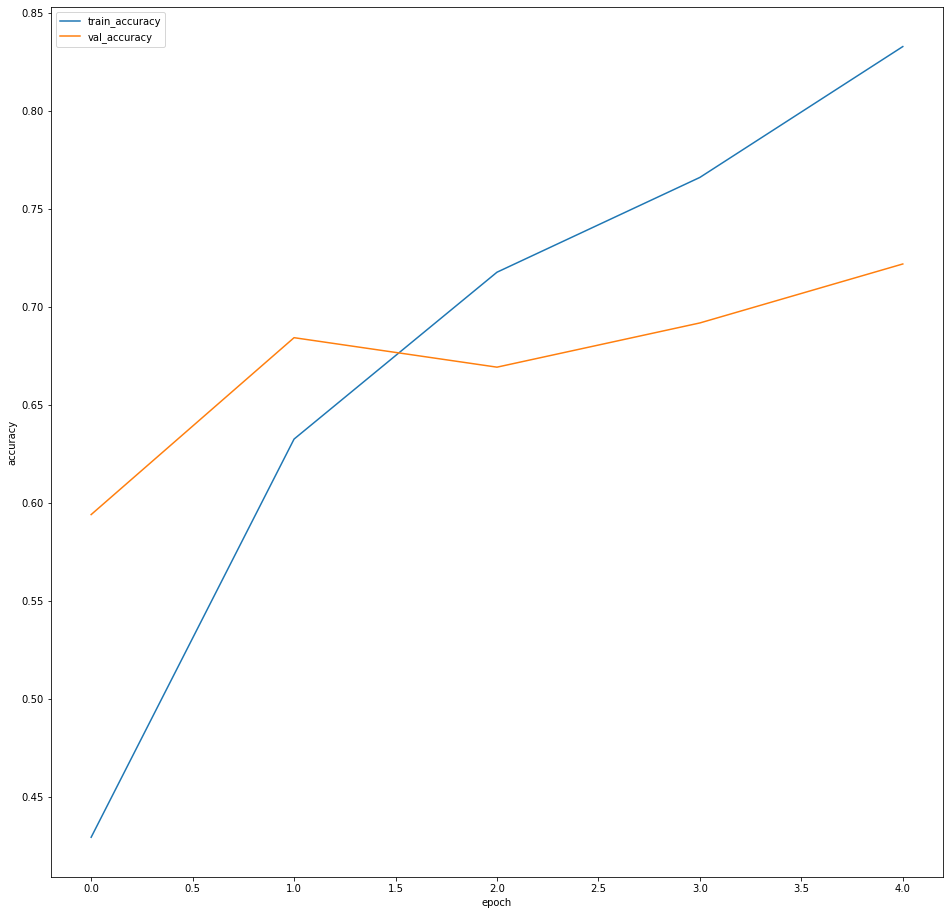

In [18]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [19]:
y_pred_prob = model.predict(image)
score = tf.nn.softmax(y_pred_prob)
y_pred = np.argmax(score, axis = 1)
print(classification_report (label, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.54      1.00      0.70         7
           2       1.00      0.64      0.78        14

    accuracy                           0.78        32
   macro avg       0.81      0.82      0.78        32
weighted avg       0.86      0.78      0.79        32



In [20]:
# The model seems to be underfitting; the training and validation losses steadily decrease with a negative slope.

In [21]:
#4 Please use data augmentation techniques to build a CNN network using TensorFlow with same network architecture. Does it 
#  produce better performance on the test dataset?
data_aug = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
    input_shape=(image_height, image_width, num_channels)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor = 0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.1))])

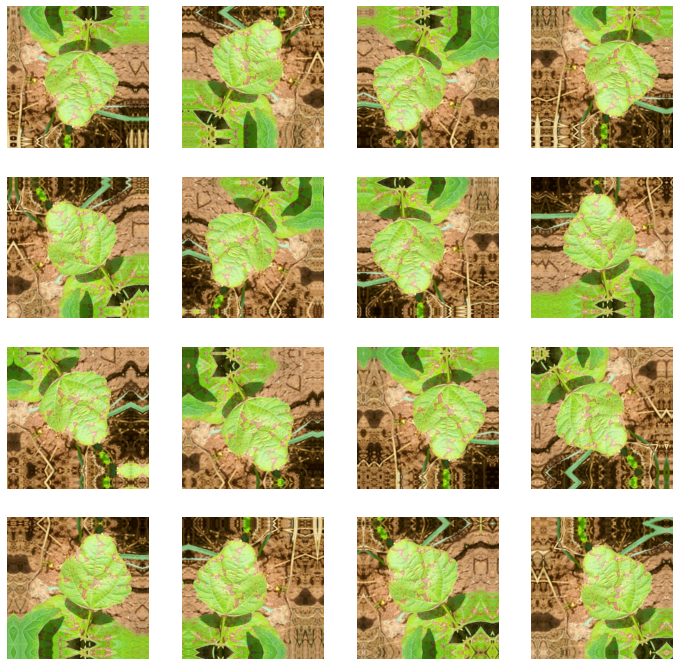

In [22]:
plt.figure(figsize=(12, 12))
for img, lab in bn_train.take(1):
    for i in range(16):
        aug_images = data_aug(img)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(aug_images[0])
        plt.axis("off")

In [23]:
model = models.Sequential(data_aug)

input_shape = image.shape

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape[1:]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(3))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 121, 121, 64)     

In [25]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [26]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
history = model.fit(bn_train, epochs=5, 
                    validation_data=(bn_validation), callbacks=[callback], verbose = 1)

Epoch 1/5
33/33 [==============================] - 299s 9s/step - loss: 2.3420 - accuracy: 0.4594 - val_loss: 0.8486 - val_accuracy: 0.5263
Epoch 2/5
33/33 [==============================] - 285s 9s/step - loss: 0.9513 - accuracy: 0.5416 - val_loss: 0.8510 - val_accuracy: 0.6015
Epoch 3/5
33/33 [==============================] - 295s 9s/step - loss: 0.8411 - accuracy: 0.5803 - val_loss: 0.7759 - val_accuracy: 0.5865
Epoch 4/5
33/33 [==============================] - 292s 9s/step - loss: 0.7953 - accuracy: 0.6296 - val_loss: 0.8977 - val_accuracy: 0.6165
Epoch 5/5
33/33 [==============================] - 297s 9s/step - loss: 0.7539 - accuracy: 0.6547 - val_loss: 0.9232 - val_accuracy: 0.6090
CPU times: total: 2h 15min 51s
Wall time: 24min 28s


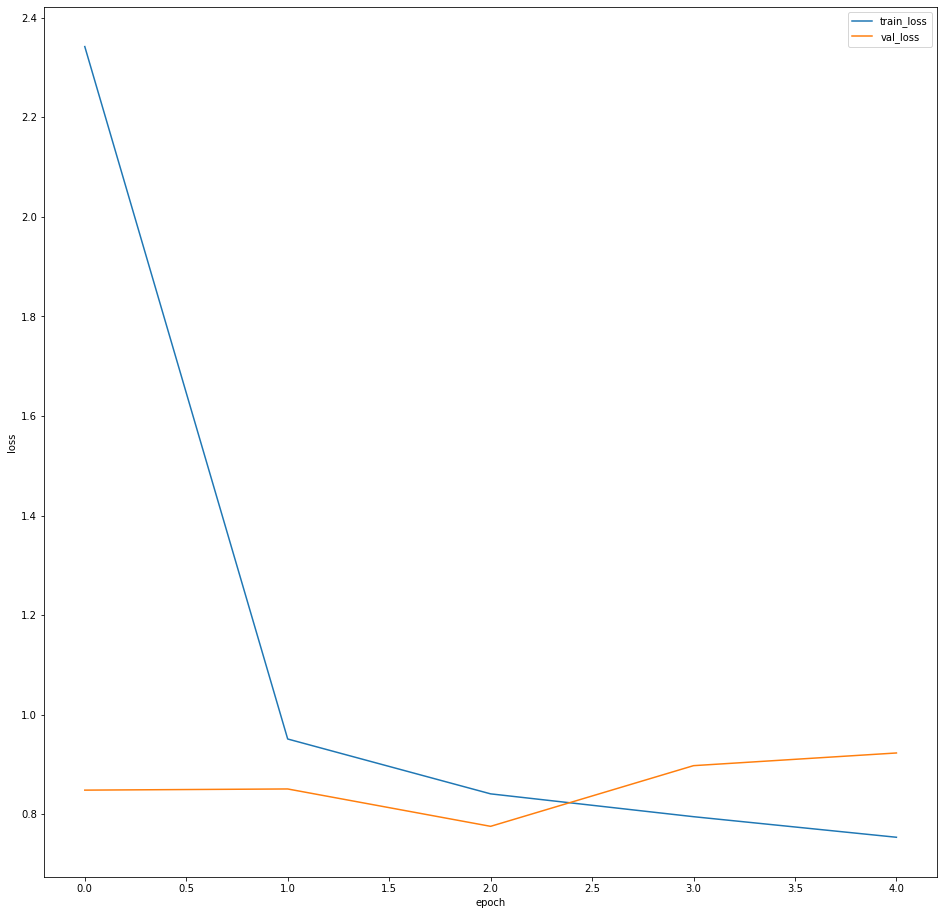

In [27]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data = train_history)
sns.lineplot(x='epoch', y ='val_loss', data = train_history)
plt.legend(labels=['train_loss', 'val_loss'])

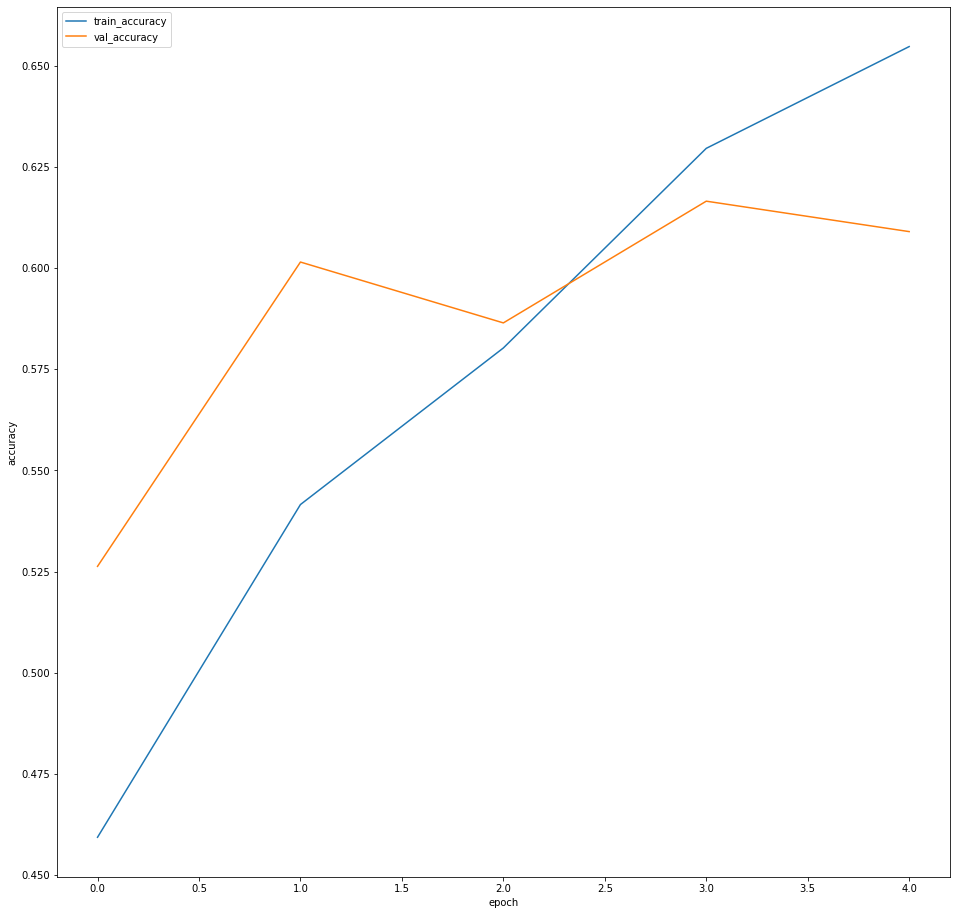

In [28]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [29]:
y_pred_prob = model.predict(image)
score = tf.nn.softmax(y_pred_prob)
y_pred = np.argmax(score, axis = 1)
print(classification_report (label, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.36      0.53        11
           1       0.57      0.57      0.57         7
           2       0.67      1.00      0.80        14

    accuracy                           0.69        32
   macro avg       0.75      0.65      0.63        32
weighted avg       0.76      0.69      0.66        32



In [30]:
# The model does not seem to produce better performance; the accuracy is only 0.31 while the accuracy of the Q3 model was 0.94.

In [31]:
#5 Build a CNN network using transfer learning and TensorFlow by choosing a pre-trained model. Does it produce better 
#  performance on the test datasets?

In [32]:
IMG_SHAPE = (image_height, image_width, num_channels)

MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

In [33]:
MobileNetV3Large_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 500, 500, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 250, 250, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [34]:
tf.keras.utils.plot_model(MobileNetV3Large_model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
MobileNetV3Large_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [36]:
image_batch, label_batch = next(iter(bn_train))
feature_batch = MobileNetV3Large_model(image_batch)
print(feature_batch.shape)

(32, 1, 1, 1280)


In [37]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [38]:
Flatten_layer = tf.keras.layers.Flatten()
feature_batch_average = Flatten_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [39]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(f' The size of the predicted value for a given batch = {prediction_batch.shape}')
print(prediction_batch)

 The size of the predicted value for a given batch = (32, 3)
tf.Tensor(
[[-0.13813421 -0.5419655   0.8564097 ]
 [-0.1341795  -0.5183478   0.83239156]
 [-0.14332074 -0.5085068   0.82930017]
 [-0.143654   -0.5073693   0.8235134 ]
 [-0.13988528 -0.5152558   0.8281765 ]
 [-0.14854966 -0.54134923  0.8443922 ]
 [-0.13676211 -0.523425    0.81505096]
 [-0.12731835 -0.53355527  0.8654502 ]
 [-0.1526829  -0.50819564  0.83218575]
 [-0.12813333 -0.5363978   0.8549922 ]
 [-0.12187551 -0.511185    0.8449049 ]
 [-0.11590075 -0.51958364  0.82600003]
 [-0.12794791 -0.5299103   0.8491091 ]
 [-0.12024462 -0.5207701   0.83536065]
 [-0.13632092 -0.5323258   0.83148324]
 [-0.14561328 -0.5046432   0.8195665 ]
 [-0.15046823 -0.5066334   0.8202107 ]
 [-0.1441264  -0.5184234   0.84155387]
 [-0.12629732 -0.52951694  0.84229606]
 [-0.15152483 -0.5039724   0.82267267]
 [-0.14008251 -0.520817    0.84338135]
 [-0.13820389 -0.52156615  0.8242554 ]
 [-0.13830191 -0.50539666  0.8377382 ]
 [-0.14168978 -0.50872743  0.83

In [40]:
inputs = tf.keras.Input(shape = IMG_SHAPE)

x = data_aug(inputs)
x = preprocess_input(x)

x = MobileNetV3Large_model(x, training=False)

x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [41]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\srgra\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 3843  

In [43]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [44]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
history = model.fit(bn_train, epochs= 5, validation_data=(bn_validation), callbacks=[callback], verbose = 1)

Epoch 1/5
33/33 [==============================] - 171s 5s/step - loss: 1.1677 - accuracy: 0.3346 - val_loss: 1.1027 - val_accuracy: 0.3308
Epoch 2/5
33/33 [==============================] - 158s 5s/step - loss: 1.1260 - accuracy: 0.3162 - val_loss: 1.1000 - val_accuracy: 0.3383
Epoch 3/5
33/33 [==============================] - 159s 5s/step - loss: 1.1317 - accuracy: 0.3269 - val_loss: 1.0995 - val_accuracy: 0.2857
Epoch 4/5
33/33 [==============================] - 158s 5s/step - loss: 1.1337 - accuracy: 0.3182 - val_loss: 1.1000 - val_accuracy: 0.3383
Epoch 5/5
33/33 [==============================] - 158s 5s/step - loss: 1.1289 - accuracy: 0.3308 - val_loss: 1.0992 - val_accuracy: 0.3083
CPU times: total: 1h 15min 47s
Wall time: 13min 24s


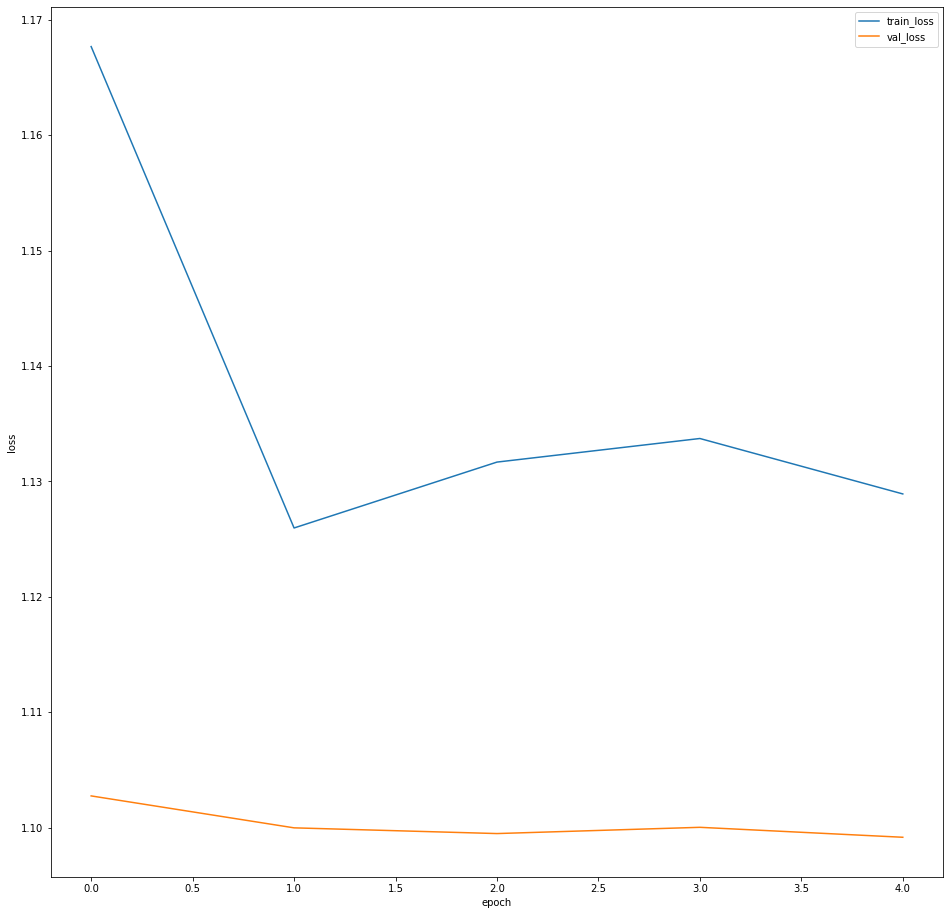

In [45]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data = train_history)
sns.lineplot(x='epoch', y ='val_loss', data = train_history)
plt.legend(labels=['train_loss', 'val_loss'])

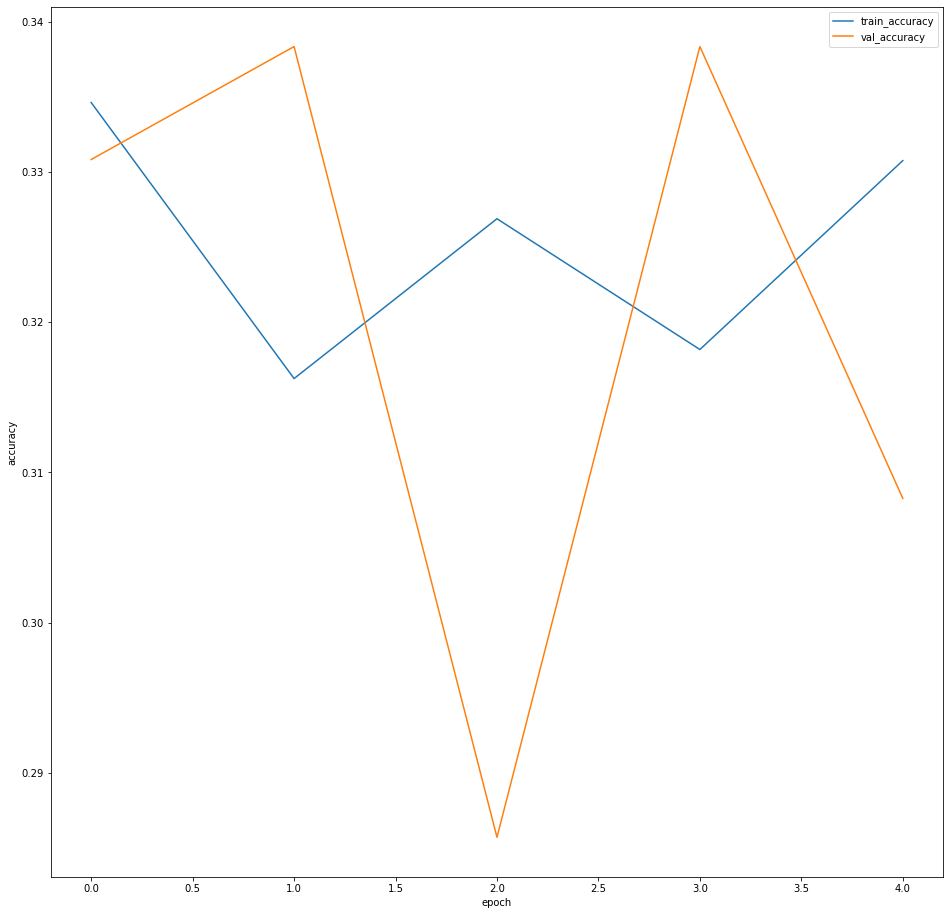

In [46]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [47]:
y_pred_prob = model.predict(image)
score = tf.nn.softmax(y_pred_prob)
y_pred = np.argmax(score, axis = 1)
print(classification_report (label, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.18      0.16        11
           1       0.17      0.43      0.24         7
           2       0.00      0.00      0.00        14

    accuracy                           0.16        32
   macro avg       0.10      0.20      0.13        32
weighted avg       0.09      0.16      0.11        32



C:\Users\srgra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srgra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srgra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# The model does not seem to produce better performance; the accuracy is only 0.34 while the accuracy of the Q3 model was 0.94.